In [1]:
# !pip install interpret
# !pip install --user xgboost
# !pip install pytorch-tabnet
# !pip install EMP-PY
# !pip uninstall lightgbm -y
# !pip install lightgbm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from interpret import preserve, show
import warnings
from sklearn import metrics
import time, datetime
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

random_state=42

In [3]:
dataset_folder = 'datasets/Maven Dataset/'
file = 'telecom_customer_churn.csv'
# cannot use heldout, don't have labels
class_names = [0, 1]
_class = 'Customer Status'

# https://www.kaggle.com/code/zakriasaad1/customer-churn-prediction-on-telecom-dataset

In [4]:
df = pd.read_csv(dataset_folder + file)
# Check duplicated values
print(df.duplicated().sum())
# df.drop(['Customer ID', 'Churn Category', 'Churn Reason'], axis=1, inplace=True)
df.columns=df.columns.str.replace(" ","").str.lower()
df=df.loc[~df.customerstatus.str.contains('Join')] # join is not useful entry for us
df.customerstatus.replace(('Churned', 'Stayed'), (1, 0), inplace=True)
# df=df.drop(columns=['customerid','churncategory','churnreason','totalrefunds','zipcode','longitude','latitude','city'])
df=df.drop(columns=['customerid','churncategory','churnreason','zipcode','longitude','latitude'])
_class = _class.replace(" ","").lower()
df.info()

0
<class 'pandas.core.frame.DataFrame'>
Index: 6589 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gender                         6589 non-null   object 
 1   age                            6589 non-null   int64  
 2   married                        6589 non-null   object 
 3   numberofdependents             6589 non-null   int64  
 4   city                           6589 non-null   object 
 5   numberofreferrals              6589 non-null   int64  
 6   tenureinmonths                 6589 non-null   int64  
 7   offer                          2991 non-null   object 
 8   phoneservice                   6589 non-null   object 
 9   avgmonthlylongdistancecharges  5945 non-null   float64
 10  multiplelines                  5945 non-null   object 
 11  internetservice                6589 non-null   object 
 12  internettype                   5245 non-null   obje

# Missing Values

In [6]:
df.avgmonthlylongdistancecharges=df.avgmonthlylongdistancecharges.fillna(0.0)

In [7]:
df.multiplelines=df.multiplelines.fillna('no phone service')

In [8]:
no_internet=['internettype','onlinesecurity','onlinebackup','deviceprotectionplan','premiumtechsupport','streamingtv',
             'streamingmovies','streamingmusic','unlimiteddata']
df[no_internet]=df[no_internet].fillna('no internet service')

In [9]:
df.avgmonthlygbdownload=df.avgmonthlygbdownload.fillna(0)

In [10]:
df.reset_index(drop=True,inplace=True)

In [11]:
# Check null values
df.isnull().sum()

gender                              0
age                                 0
married                             0
numberofdependents                  0
city                                0
numberofreferrals                   0
tenureinmonths                      0
offer                            3598
phoneservice                        0
avgmonthlylongdistancecharges       0
multiplelines                       0
internetservice                     0
internettype                        0
avgmonthlygbdownload                0
onlinesecurity                      0
onlinebackup                        0
deviceprotectionplan                0
premiumtechsupport                  0
streamingtv                         0
streamingmovies                     0
streamingmusic                      0
unlimiteddata                       0
contract                            0
paperlessbilling                    0
paymentmethod                       0
monthlycharge                       0
totalcharges

In [12]:
# Check unique values in each column
for col in df.columns:
    if df[col].dtype == 'object':
        unique_vals = df[col].unique()
        print(f"Unique Values of {col} Column:")
        print(unique_vals)
        print()

Unique Values of gender Column:
['Female' 'Male']

Unique Values of married Column:
['Yes' 'No']

Unique Values of city Column:
['Frazier Park' 'Glendale' 'Costa Mesa' ... 'Kirkwood' 'Carpinteria'
 'Meadow Valley']

Unique Values of offer Column:
[nan 'Offer E' 'Offer D' 'Offer A' 'Offer B' 'Offer C']

Unique Values of phoneservice Column:
['Yes' 'No']

Unique Values of multiplelines Column:
['No' 'Yes' 'no phone service']

Unique Values of internetservice Column:
['Yes' 'No']

Unique Values of internettype Column:
['Cable' 'Fiber Optic' 'DSL' 'no internet service']

Unique Values of onlinesecurity Column:
['No' 'Yes' 'no internet service']

Unique Values of onlinebackup Column:
['Yes' 'No' 'no internet service']

Unique Values of deviceprotectionplan Column:
['No' 'Yes' 'no internet service']

Unique Values of premiumtechsupport Column:
['Yes' 'No' 'no internet service']

Unique Values of streamingtv Column:
['Yes' 'No' 'no internet service']

Unique Values of streamingmovies Column:


In [13]:
# Check our target column
df[_class].value_counts()

customerstatus
0    4720
1    1869
Name: count, dtype: int64

## Preprocessing Data

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6589 entries, 0 to 6588
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gender                         6589 non-null   object 
 1   age                            6589 non-null   int64  
 2   married                        6589 non-null   object 
 3   numberofdependents             6589 non-null   int64  
 4   city                           6589 non-null   object 
 5   numberofreferrals              6589 non-null   int64  
 6   tenureinmonths                 6589 non-null   int64  
 7   offer                          2991 non-null   object 
 8   phoneservice                   6589 non-null   object 
 9   avgmonthlylongdistancecharges  6589 non-null   float64
 10  multiplelines                  6589 non-null   object 
 11  internetservice                6589 non-null   object 
 12  internettype                   6589 non-null   o

In [16]:
from sklearn.preprocessing import LabelEncoder

# Encoding categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6589 entries, 0 to 6588
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gender                         6589 non-null   int32  
 1   age                            6589 non-null   int64  
 2   married                        6589 non-null   int32  
 3   numberofdependents             6589 non-null   int64  
 4   city                           6589 non-null   int32  
 5   numberofreferrals              6589 non-null   int64  
 6   tenureinmonths                 6589 non-null   int64  
 7   offer                          6589 non-null   int32  
 8   phoneservice                   6589 non-null   int32  
 9   avgmonthlylongdistancecharges  6589 non-null   float64
 10  multiplelines                  6589 non-null   int32  
 11  internetservice                6589 non-null   int32  
 12  internettype                   6589 non-null   i

In [18]:
# List of categoricals

def list_categoricals(df):
    categoricals = list()
    for x in df.columns:
        if df[x].dtype == 'object':
            categoricals.append(x)
    display(df[categoricals].nunique())
    return categoricals

categoricals = list_categoricals(df)


Series([], dtype: float64)

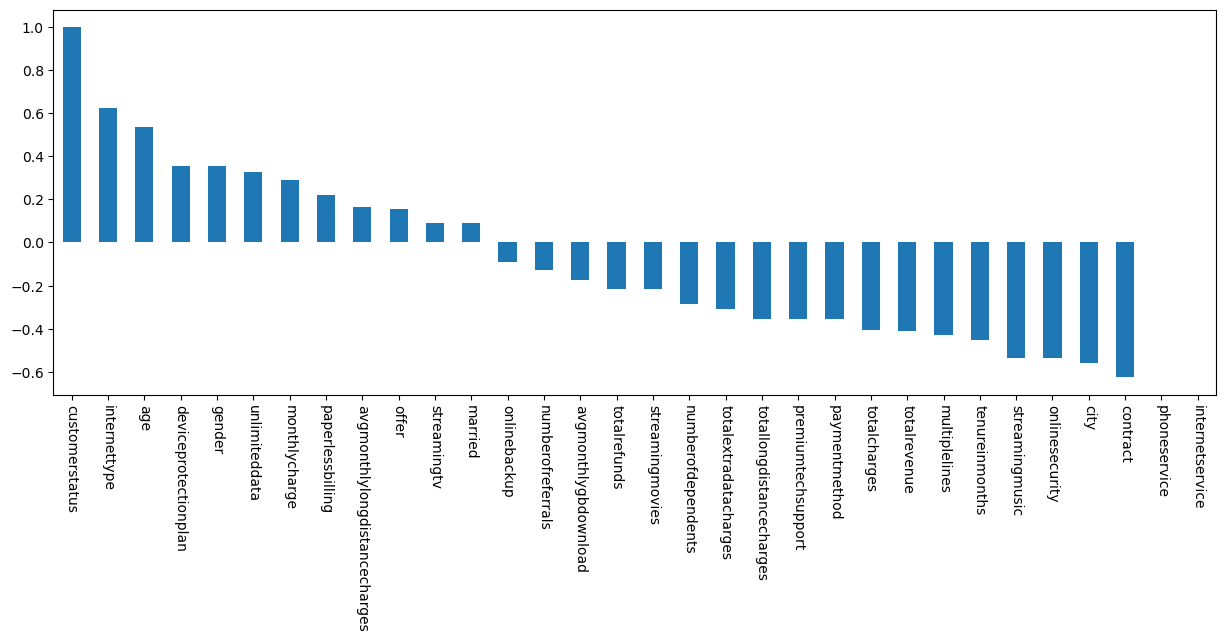

In [19]:
numericals = [x for x in df.columns if x not in categoricals]

plt.figure(figsize=(15,5))
plt.grid(True)
df[numericals].head(10).corr()[_class].sort_values(ascending = False).plot(kind='bar')
plt.xticks(rotation=-90)
plt.show()

In [20]:
df.shape

(6589, 32)

In [21]:
# Categoricals

In [22]:
df = pd.get_dummies(df, drop_first=True)

# Calculate customer value [Estimated by Atif]
df['customer_value'] = df['totalrevenue'] / df['tenureinmonths'].apply(lambda x: x+1) # plus 1 month in tenure


tenure_column = 'tenureinmonths' 

In [23]:
df[['totalrevenue', tenure_column, 'customer_value']].sort_values(by=['customer_value'], ascending=True).head(n=15)

# these are all monthly charges

,totalrevenue,tenureinmonths,customer_value
4389,21.61,1,10.805000
3817,22.54,1,11.270000
5212,23.24,1,11.620000
2486,23.45,1,11.725000
643,24.21,1,12.105000
866,24.25,1,12.125000
1900,36.55,2,12.183333
6037,24.45,1,12.225000
6085,24.60,1,12.300000
3092,24.75,1,12.375000


In [24]:
df.shape

(6589, 33)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6589 entries, 0 to 6588
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gender                         6589 non-null   int32  
 1   age                            6589 non-null   int64  
 2   married                        6589 non-null   int32  
 3   numberofdependents             6589 non-null   int64  
 4   city                           6589 non-null   int32  
 5   numberofreferrals              6589 non-null   int64  
 6   tenureinmonths                 6589 non-null   int64  
 7   offer                          6589 non-null   int32  
 8   phoneservice                   6589 non-null   int32  
 9   avgmonthlylongdistancecharges  6589 non-null   float64
 10  multiplelines                  6589 non-null   int32  
 11  internetservice                6589 non-null   int32  
 12  internettype                   6589 non-null   i

In [26]:
X, y = df.drop(columns=[_class]), df[_class]

In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=random_state)

In [28]:
x_test.shape

(1977, 32)

# Feature Selection

In [30]:
# from sklearn.linear_model import LassoCV

# lasso = LassoCV(tol=0.0001).fit(x_train, y_train)
# importance = np.abs(lasso.coef_)
# print(len([x for x in importance if x != 0]))

In [31]:
# from sklearn.feature_selection import SelectFromModel
# sfm = SelectFromModel(lasso).fit(x_train, y_train)

# selected_feat = x_train.columns[(sfm.get_support())]
# print(selected_feat)

# x_train = sfm.transform(x_train)
# x_test = sfm.transform(x_test)

In [32]:
# x_train = pd.DataFrame(x_train, columns=selected_feat)
# x_train.index = y_train.index
# x_test = pd.DataFrame(x_test, columns=selected_feat)
# x_test.index = y_test.index

In [33]:
# y_test

In [34]:
x_train.shape

(4612, 32)

# EDA

In [36]:
# data = x_train
# corr = data.corr()
# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))
# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))
# ax = sns.heatmap(
#     corr, mask=mask,
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True,  cbar_kws={"shrink": .5}
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );

In [37]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4612 entries, 1114 to 860
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   gender                         4612 non-null   int32  
 1   age                            4612 non-null   int64  
 2   married                        4612 non-null   int32  
 3   numberofdependents             4612 non-null   int64  
 4   city                           4612 non-null   int32  
 5   numberofreferrals              4612 non-null   int64  
 6   tenureinmonths                 4612 non-null   int64  
 7   offer                          4612 non-null   int32  
 8   phoneservice                   4612 non-null   int32  
 9   avgmonthlylongdistancecharges  4612 non-null   float64
 10  multiplelines                  4612 non-null   int32  
 11  internetservice                4612 non-null   int32  
 12  internettype                   4612 non-null   int3

In [38]:
# Churn distribution
# plt.figure(figsize=(6, 4))
# sns.countplot(x='churn', data=y_test.to_frame(), palette='viridis')
# plt.title('Churn Distribution')
# plt.xlabel('Churn')
# plt.ylabel('Count')
# plt.show()

# ML Model

In [40]:
import sklearn.metrics
import pandas as pd
import time
import numpy as np

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from interpret.glassbox import ExplainableBoostingClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

In [42]:
random_state=42

In [43]:
x_train

,gender,age,married,numberofdependents,city,numberofreferrals,tenureinmonths,offer,phoneservice,avgmonthlylongdistancecharges,...,contract,paperlessbilling,paymentmethod,monthlycharge,totalcharges,totalrefunds,totalextradatacharges,totallongdistancecharges,totalrevenue,customer_value
1114,0,30,0,0,664,0,54,1,1,37.65,...,1,1,0,94.75,5121.75,0.0,70,2033.10,7224.85,131.360909
798,0,53,1,0,348,4,72,5,1,2.95,...,2,1,0,91.15,6637.90,0.0,0,212.40,6850.30,93.839726
4623,1,27,0,0,554,0,47,5,1,6.61,...,2,0,0,20.45,943.00,0.0,0,310.67,1253.67,26.118125
298,1,47,0,0,757,0,43,1,1,49.13,...,0,1,0,77.85,3365.85,0.0,0,2112.59,5478.44,124.510000
2879,0,23,0,0,787,0,42,1,1,29.44,...,1,1,0,60.15,2421.60,0.0,0,1236.48,3658.08,85.071628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,1,29,0,0,654,0,41,1,1,21.64,...,2,1,1,99.65,4220.35,0.0,0,887.24,5107.59,121.609286
5191,0,32,0,0,820,0,2,5,1,41.37,...,0,1,0,75.55,166.30,0.0,0,82.74,249.04,83.013333
5226,0,49,1,1,680,10,53,1,1,30.31,...,1,0,0,19.55,1007.90,0.0,0,1606.43,2614.33,48.413519
5390,0,26,0,1,447,0,43,5,1,5.60,...,0,1,0,63.95,2737.05,0.0,0,240.80,2977.85,67.678409


In [44]:
# Grid Search

In [45]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Define parameter grids for each model
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_gbc = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.3, 0.7]
}

# param_grid_tabnet = {
#     'n_d': [8, 16, 24],
#     'n_a': [8, 16, 24],
#     'n_steps': [3, 5, 7],
#     'gamma': [1.0, 1.5, 2.0]
# }

param_grid_ebm = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_bins': [128, 256],
    'max_interaction_bins': [16, 32],
    'interactions': [10, 20]
}

param_grid_cbc = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 5],
}

param_grid_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50],
}

# Initialize the models
rf = RandomForestClassifier(random_state=random_state)
gbc = GradientBoostingClassifier(random_state=random_state)
_xgb = xgb.XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss')
cbc = CatBoostClassifier(verbose=0, random_state=42)
lgbm = LGBMClassifier(random_state=42)
# tabnet = TabNetClassifier(verbose=0, seed=random_state)
ebm = ExplainableBoostingClassifier(random_state=random_state)

In [46]:
def gridsearch_now(model, param_grid, x, y, cv, scoring, refit=True, verbose=None, _name=None):
    if refit == 'emp':
        n_jobs = 1
    else:
        n_jobs = -1
    now = datetime.datetime.now()
    if _name:
        print(_name.title(), 'at', now)
    else:
        print('At', now)
    start = time.time()
    if verbose:
        gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, n_jobs=n_jobs, verbose=verbose)
    else:
        gs = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, refit=refit, n_jobs=n_jobs)
    gs.fit(x_train, y_train)
    taken = time.time() - start
    print(f' > done; taken {taken:.2f}')
    return gs

In [47]:
clfs_with_grids = [(rf, param_grid_rf, 'rf', True), (gbc, param_grid_gbc, 'gbc', True), 
                   (_xgb, param_grid_xgb, 'xgb', True), (cbc, param_grid_cbc, 'cbc', True), 
                   (lgbm, param_grid_lgbm, 'lgbm', True),
                   (ebm, param_grid_ebm, 'ebm', True)]

## Custom Metrics

### eProfits

In [50]:
# !pip install lifelines

(4612,) (4612,)


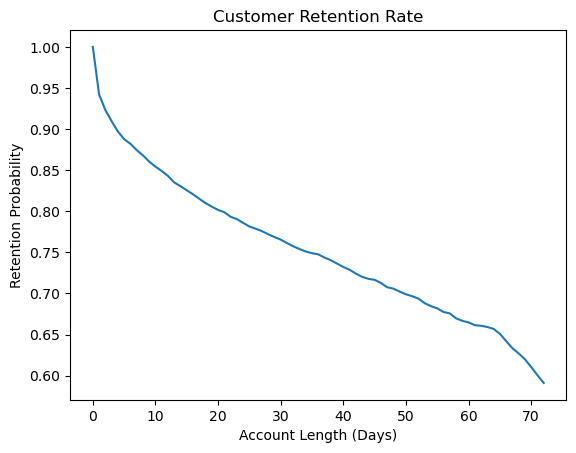

Retention rate at 34.56 days: 75.11%
0.854324609923966


'Average Retention Rate  0.75'

In [51]:
# obtain retention
from lifelines import KaplanMeierFitter

# Survival Analysis: The Kaplan-Meier estimator is used to model the time until an event (e.g., churn) and estimate the retention rate over time.

def get_retention_rate():

    tenure = x_train[tenure_column].values
    event_observed = y_train.values

    print(tenure.shape, event_observed.shape)
    
    # Kaplan-Meier Estimator
    kmf = KaplanMeierFitter()
    kmf.fit(tenure, event_observed=event_observed)
    
    # Plot the survival function
    # print(kmf.survival_function_)
    plt.plot(kmf.survival_function_)
    plt.title('Customer Retention Rate')
    plt.xlabel('Account Length (Days)')
    plt.ylabel('Retention Probability')
    plt.show()
    
    # Estimate retention rate at specific time points
    avg_tenure = tenure.mean()
    retention_rate = kmf.survival_function_at_times(avg_tenure).values[0]
    print(f'Retention rate at {avg_tenure:.2f} days: {retention_rate * 100:.2f}%')
    return retention_rate, lambda x: kmf.survival_function_at_times(x).values[0]

avg_retention_rate, retention_fn = get_retention_rate()
print(retention_fn(10))
f'Average Retention Rate {avg_retention_rate: .2f}'

In [52]:
def estimate_clv_and_cost_of_intervention(df, i, Profit_Margin=0.3, CPO = 0.1):
    # Estimate of Customer Life Time Value: [(CV_daily * 30) * Profit Margin/ ((1 - retention_rate))]
    monthly_revenue = df.iloc[i]['customer_value']
    retention_rate = min(0.995, df.iloc[i]['retention_rate']) # retention rate can never be 1
    clv = (monthly_revenue * Profit_Margin) / (1 - retention_rate)
    
    # Example: Cost of intervention is 10% of CLV adjusted by account length
    base_cost = CPO * clv
    # adjustment_factor = 1 + (df.iloc[i]['accountlength'] / 100)  # Example adjustment
    # cost_per_offer = base_cost * adjustment_factor
    cost_per_offer = base_cost
    return clv, cost_per_offer
    
# Our Metric calculation function
def _eprofits(df, Profit_Margin, Cost_of_Contact, CPO, verbose=0):
    profits = []
    for i in range(len(df)):
        clv, cost_per_offer = estimate_clv_and_cost_of_intervention(df, i, Profit_Margin, CPO)
        cost_of_contact = max(Cost_of_Contact[0], Cost_of_Contact[1]*cost_per_offer)
        if df.iloc[i]['true'] == 1 and df.iloc[i]['predict'] == df.iloc[i]['true']:   # chruners predicted as churners
            profit = clv - cost_per_offer - cost_of_contact
            if verbose:
                print(profit, i, df.iloc[i]['true'], df.iloc[i]['predict'])
        elif df.iloc[i]['predict'] == 1:  # not chruners predicted as churners
            profit = -cost_per_offer - cost_of_contact
            if verbose:
                print(profit, i, df.iloc[i]['true'], df.iloc[i]['predict'])
        # elif df.iloc[i]['true'] == 1:  # chruners but not predicted as churners
        #     profit = -clv
        #     if verbose:
        #         print(profit, i, df.iloc[i]['true'], df.iloc[i]['predict'])
        else:
            profit = 0 # not churners and not predicted as churners
        profits.append(profit)
    return sum(profits)

In [53]:
Profit_Margin = 0.3
Cost_of_Contact = (0, 0.3)
CPO = 0.1

def custom_eprofits_function(df, Profit_Margin, Cost_of_Contact, CPO):
    def custom_scorer(y_true, y_pred):
        my_df = df.loc[y_true.index]
        my_df['true'] = y_true
        my_df['predict'] = y_pred
        return _eprofits(my_df, Profit_Margin, Cost_of_Contact, CPO)
    return metrics.make_scorer(custom_scorer, greater_is_better=True)

df_eprofits_scorer_train = pd.DataFrame({'customer_value': x_train['customer_value'], 'retention_rate': x_train[tenure_column].apply(retention_fn)})
eprofits_scorer_train = custom_eprofits_function(df_eprofits_scorer_train, Profit_Margin, Cost_of_Contact, CPO)

In [54]:
from EMP.metrics import empChurn


# Define the custom scorer function
def emp_scorer(estimator, X, y):
    # Use the model to predict probabilities
    y_proba = estimator.predict_proba(X)[:, 1]  # Assuming binary classification and taking the probability of class 1
    return empChurn(y_proba, y, alpha=6, beta=14, clv=200, d=10, f=1, print_output=False, return_output=True, rounding=None).EMP

# Create the custom scorer using make_scorer
custom_emp_function = metrics.make_scorer(emp_scorer, greater_is_better=True, needs_proba=True)

In [55]:
# Define scoring method
# scoring = {'AUC': 'roc_auc'}
# scoring = 'accuracy'
# scoring = 'f1'


full_scoring_dict = {
    'AUC': metrics.make_scorer(metrics.roc_auc_score),
    'accuracy': metrics.make_scorer(metrics.accuracy_score),
    'f1': metrics.make_scorer(metrics.f1_score),
    'emp': custom_emp_function,
    'eprofits': eprofits_scorer_train,
}

## GridSearch

In [57]:
def run_grid_search(full_scoring_dict):
    grid_search_dict = {}
    for sc_policy, scorer_fn in full_scoring_dict.items():
        _scoring = {sc_policy: scorer_fn}
        refit = sc_policy
        print('With scoring', sc_policy)
        for clf, param_grid, _name, _ in clfs_with_grids:
            if not _name in grid_search_dict:
                grid_search_dict[_name] = {}
            grid_search_dict[_name][sc_policy] = gridsearch_now(clf, param_grid, x_train, y_train, 5, _scoring, refit, verbose=1, _name=_name)
    return grid_search_dict


grid_search_dict = run_grid_search(full_scoring_dict)

With scoring AUC
Rf at 2025-05-21 14:54:26.213988
Fitting 5 folds for each of 108 candidates, totalling 540 fits
 > done; taken 188.42
Gbc at 2025-05-21 14:57:34.634240
Fitting 5 folds for each of 27 candidates, totalling 135 fits
 > done; taken 148.70
Xgb at 2025-05-21 15:00:03.331487
Fitting 5 folds for each of 54 candidates, totalling 270 fits
 > done; taken 20.16
Cbc at 2025-05-21 15:00:23.492419
Fitting 5 folds for each of 8 candidates, totalling 40 fits
 > done; taken 12.41
Lgbm at 2025-05-21 15:00:35.900286
Fitting 5 folds for each of 8 candidates, totalling 40 fits


  File "C:\Users\Awais.Manzoor\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Awais.Manzoor\AppData\Local\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Awais.Manzoor\AppData\Local\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Awais.Manzoor\AppData\Local\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Number of positive: 1299, number of negative: 3313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2182
[LightGBM] [Info] Number of data points in the train set: 4612, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.281657 -> initscore=-0.936259
[LightGBM] [Info] Start training from score -0.936259
 > done; taken 18.86
Ebm at 2025-05-21 15:00:54.764413
Fitting 5 folds for each of 24 candidates, totalling 120 fits
 > done; taken 518.14
With scoring accuracy
Rf at 2025-05-21 15:09:32.905003
Fitting 5 folds for each of 108 candidates, totalling 540 fits
 > done; taken 185.87
Gbc at 2025-05-21 15:12:38.775302
Fitting 5 folds for each of 27 candidates, totalling 135 fits
 > done; taken 124.41
Xgb at 2025-05-21 15:14:43.185031
Fitting 5 fold

In [58]:
def show_grid_search_results(scoring_list, grid_search_dict):
    grid_results = {}
    for sc_policy in scoring_list:
        print(f'For {sc_policy}')
        for clf, param_grid, _name, _ in clfs_with_grids:
            _best = grid_search_dict[_name][sc_policy].best_estimator_
            # print(_name, _best)
            y_pred = _best.predict(x_test)
            y_prob = _best.predict_proba(x_test)[:, 1]
            if not _name in grid_results:
                grid_results[_name] = {}
            grid_results[_name][sc_policy] = {'_best': _best, 'y_pred': y_pred, 'y_prob': y_prob}
        
        for clf, param_grid, _name, _ in clfs_with_grids:
            y_prob = grid_results[_name][sc_policy]['y_prob']
            print(f' Best {_name} AUC: {metrics.roc_auc_score(y_test, y_prob)}')
    return grid_results

grid_results = show_grid_search_results(full_scoring_dict.keys(), grid_search_dict)

For AUC
 Best rf AUC: 0.9284068379904986
 Best gbc AUC: 0.937784760408484
 Best xgb AUC: 0.9381825209790645
 Best cbc AUC: 0.9430666217783265
 Best lgbm AUC: 0.9383957405952692
 Best ebm AUC: 0.9424893078467311
For accuracy
 Best rf AUC: 0.9298844125238469
 Best gbc AUC: 0.937784760408484
 Best xgb AUC: 0.9425416775770272
 Best cbc AUC: 0.9430666217783265
 Best lgbm AUC: 0.9406563672863753
 Best ebm AUC: 0.9424893078467311
For f1
 Best rf AUC: 0.9284068379904986
 Best gbc AUC: 0.937784760408484
 Best xgb AUC: 0.9396289230539034
 Best cbc AUC: 0.9430666217783265
 Best lgbm AUC: 0.9383957405952692
 Best ebm AUC: 0.9424893078467311
For emp
 Best rf AUC: 0.9265938478035887
 Best gbc AUC: 0.9186772902405267
 Best xgb AUC: 0.9187003578598238
 Best cbc AUC: 0.9220582550904625
 Best lgbm AUC: 0.9355696455068018
 Best ebm AUC: 0.9424893078467311
For eprofits
 Best rf AUC: 0.9284068379904986
 Best gbc AUC: 0.937784760408484
 Best xgb AUC: 0.9381825209790645
 Best cbc AUC: 0.9430666217783265
 Bes

In [59]:
df_eprofits_scorer_test = pd.DataFrame({'customer_value': x_test['customer_value'], 'retention_rate': x_test[tenure_column].apply(retention_fn)})

def classify_report(clfs, dataset):
    x_train, y_train, x_test, y_test = dataset
    data = []
    my_df = df_eprofits_scorer_test.copy(deep=True)
    my_df['true'] = y_test
    
    for clf, name, no_df in clfs:
        if no_df:
            x_tr, x_te = x_train, x_test
        else:
            x_tr, x_te = x_train.values,  x_test.values
        clf.fit(x_tr, y_train)
        pred = clf.predict(x_te)
        y_scores = clf.predict_proba(x_te)[:, 1]
        my_df['predict'] = pred
        _eprof = _eprofits(my_df, Profit_Margin=Profit_Margin, Cost_of_Contact= Cost_of_Contact, CPO=CPO, verbose=0)
        _emp = empChurn(y_scores, y_test, alpha=6, beta=14, clv=200, d=10, f=1, print_output=False, return_output=True, rounding=None).EMP
        f1, acc, auc = sklearn.metrics.f1_score(y_test, pred, average='binary'), sklearn.metrics.accuracy_score(y_test, pred), sklearn.metrics.roc_auc_score(y_test, pred)
        data.append([name, f1, acc, auc, _eprof, _emp])
    df = pd.DataFrame(data, columns = ['Name', 'F1', 'Acc.', 'ROC_AUC', 'eProfits', 'EMP'])
    df = df.sort_values(by=['F1'])
    return df

In [60]:
def get_models(grid_results, sc_policy):
    rf = grid_results['rf'][sc_policy]['_best']
    gbc = grid_results['gbc'][sc_policy]['_best']
    _xgb = grid_results['xgb'][sc_policy]['_best']
    cbc = grid_results['cbc'][sc_policy]['_best']
    # lgbm = grid_results['lgbm'][sc_policy]['_best']
    ebm = grid_results['ebm'][sc_policy]['_best']
    # tbn = grid_results['tbn'][sc_policy]['_best']
    # model = [(rf, 'rf', True), (gbc, 'gbc', True), (_xgb, 'xgb', True), (ebm, 'ebm', True), (tbn, 'tbn', False)]
    models = [(rf, 'rf', True), (gbc, 'gbc', True), (_xgb, 'xgb', True), (cbc, 'cbc', True), (lgbm, 'lgbm', True), (ebm, 'ebm', True)]
    return models

In [61]:
def get_model_report_dfs(scoring_list, grid_results):
    model_report_dfs_dict = {}
    for sc_policy in scoring_list:
        print(f'By {sc_policy}')
        models = get_models(grid_results, sc_policy)
        dataset = x_train, y_train, x_test, y_test
        model_report_dfs_dict[sc_policy] = classify_report(models, dataset)
        display(model_report_dfs_dict[sc_policy])
    return model_report_dfs_dict

model_report_dfs_dict = get_model_report_dfs(full_scoring_dict.keys(), grid_results)

By AUC
[LightGBM] [Info] Number of positive: 1299, number of negative: 3313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2182
[LightGBM] [Info] Number of data points in the train set: 4612, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.281657 -> initscore=-0.936259
[LightGBM] [Info] Start training from score -0.936259


,Name,F1,Acc.,ROC_AUC,eProfits,EMP
0,rf,0.737052,0.866464,0.801818,64092.650538,13.088539
1,gbc,0.750000,0.867476,0.814531,64715.127338,13.249239
3,cbc,0.751923,0.869499,0.814909,64919.439949,13.441589
4,lgbm,0.758751,0.871017,0.821193,65744.379924,13.372687
2,xgb,0.761364,0.872534,0.822781,66168.633804,13.282187
5,ebm,0.763981,0.874052,0.824369,66513.884889,13.469570


By accuracy
[LightGBM] [Info] Number of positive: 1299, number of negative: 3313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2182
[LightGBM] [Info] Number of data points in the train set: 4612, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.281657 -> initscore=-0.936259
[LightGBM] [Info] Start training from score -0.936259


,Name,F1,Acc.,ROC_AUC,eProfits,EMP
0,rf,0.732593,0.865959,0.797810,62904.787191,13.135352
1,gbc,0.750000,0.867476,0.814531,64715.127338,13.249239
3,cbc,0.751923,0.869499,0.814909,64919.439949,13.441589
2,xgb,0.754067,0.870005,0.816829,64986.863230,13.408551
4,lgbm,0.758751,0.871017,0.821193,65744.379924,13.372687
5,ebm,0.763981,0.874052,0.824369,66513.884889,13.469570


By f1
[LightGBM] [Info] Number of positive: 1299, number of negative: 3313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2182
[LightGBM] [Info] Number of data points in the train set: 4612, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.281657 -> initscore=-0.936259
[LightGBM] [Info] Start training from score -0.936259


,Name,F1,Acc.,ROC_AUC,eProfits,EMP
0,rf,0.737052,0.866464,0.801818,64092.650538,13.088539
1,gbc,0.750000,0.867476,0.814531,64715.127338,13.249239
3,cbc,0.751923,0.869499,0.814909,64919.439949,13.441589
2,xgb,0.758621,0.872534,0.819650,64963.069229,13.366013
4,lgbm,0.758751,0.871017,0.821193,65744.379924,13.372687
5,ebm,0.763981,0.874052,0.824369,66513.884889,13.469570


By emp
[LightGBM] [Info] Number of positive: 1299, number of negative: 3313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2182
[LightGBM] [Info] Number of data points in the train set: 4612, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.281657 -> initscore=-0.936259
[LightGBM] [Info] Start training from score -0.936259


,Name,F1,Acc.,ROC_AUC,eProfits,EMP
2,xgb,0.479361,0.802226,0.657539,34366.283657,12.787302
1,gbc,0.584767,0.829034,0.706640,43252.359139,12.773714
3,cbc,0.665946,0.843703,0.753473,54851.590718,12.755042
0,rf,0.734127,0.864441,0.800397,63746.941608,12.907524
4,lgbm,0.758751,0.871017,0.821193,65744.379924,13.372687
5,ebm,0.763981,0.874052,0.824369,66513.884889,13.469570


By eprofits
[LightGBM] [Info] Number of positive: 1299, number of negative: 3313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2182
[LightGBM] [Info] Number of data points in the train set: 4612, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.281657 -> initscore=-0.936259
[LightGBM] [Info] Start training from score -0.936259


,Name,F1,Acc.,ROC_AUC,eProfits,EMP
0,rf,0.737052,0.866464,0.801818,64092.650538,13.088539
1,gbc,0.750000,0.867476,0.814531,64715.127338,13.249239
3,cbc,0.751923,0.869499,0.814909,64919.439949,13.441589
4,lgbm,0.758751,0.871017,0.821193,65744.379924,13.372687
2,xgb,0.761364,0.872534,0.822781,66168.633804,13.282187
5,ebm,0.763981,0.874052,0.824369,66513.884889,13.469570


# Metrics

In [63]:
# Lift calculation function
def calculate_lift(y_true, y_scores, percentile=0.1):
    df = pd.DataFrame({'true': y_true, 'scores': y_scores})
    df = df.sort_values('scores', ascending=False)
    top_percentile = int(len(df) * percentile)
    top_df = df.head(top_percentile)
    lift = top_df['true'].sum() / top_percentile
    
    # Calculate the overall churn rate
    overall_churn_rate = df['true'].mean()
    top_decile_lift = top_df['true'].mean() / overall_churn_rate
    # When the lift value is higher than 1, it shows a higher density of churners in the top decile

    # Lift Index
    df['decile'] = pd.qcut(df['scores'].rank(method='first'), 10, labels=False) # first decile is actually the last one
    deciles_churners = df.groupby('decile')['true'].sum().to_frame()
    deciles_churners['weight'] = np.arange(0.1, 1.1, 0.1) # first decile is actually the last one
    deciles_churners['w_churners'] = deciles_churners['weight'] * deciles_churners['true']
    lift_index = deciles_churners['w_churners'].sum()/deciles_churners['true'].sum()
    
    return lift, top_decile_lift, lift_index

# Our eProfits calculation function
def calculate_eprofits(cv_series, y_true, y_scores, y_predict, retention_series, Profit_Margin=0.3, Cost_of_Contact = (0, 0.3), CPO=0.1, top_profitable_percentile=0.2):
    df = pd.DataFrame({'customer_value': cv_series, 'true': y_true, 'predict': y_predict, 'scores': y_scores, 'retention_rate': retention_series})
    df = df.sort_values(by=['customer_value', 'scores'], ascending=False)
    profits_full = _eprofits(df, Profit_Margin, Cost_of_Contact, CPO)
    
    top_percentile = int(len(df) * top_profitable_percentile)
    top_df = df.head(top_percentile)
    
    profits_percentile = _eprofits(top_df, Profit_Margin, Cost_of_Contact, CPO)
    return profits_percentile, profits_full

def calculate_EMP(y_true, y_scores, top_profitable_percentile=0.2):
    df = pd.DataFrame({'true': y_true, 'scores': y_scores})
    df = df.sort_values('scores', ascending=False)
    try:
        emp_full = empChurn(df['scores'], df['true'], alpha=6, beta=14, clv=200, d=10, f=1, print_output=False, return_output=True, rounding=None).EMP
    except:
        emp_full = np.nan  # usuobserved when all belong to same class, EMP is not calculatable

    
    top_percentile = int(len(df) * top_profitable_percentile)
    top_df = df.head(top_percentile)

    try:
        emp_percentile = empChurn(top_df['scores'], top_df['true'], alpha=6, beta=14, clv=200, d=10, f=1, print_output=False, return_output=True, rounding=None).EMP
    except:
        emp_percentile = np.nan  # usuobserved when all belong to same class, EMP is not calculatable
    return emp_percentile, emp_full

In [64]:
def business_metric_report(clfs, Profit_Margin=0.3, Cost_of_Contact = (0, 0.3), CPO=0.1):
    data = []
    for clf, name, no_df in clfs:
        if no_df:
            x_tr, x_te = x_train, x_test
        else:
            x_tr, x_te = x_train.values,  x_test.values
        cv_series = x_te['customer_value']
        y_scores = clf.predict_proba(x_te)[:, 1]
        y_predict = clf.predict(x_te)
        lift, top_decile_lift, lift_index = calculate_lift(y_test, y_scores)
        retention_series = x_te[tenure_column].apply(lambda x: avg_retention_rate) # avg_retention_rate
        pd.DataFrame({'customer_value': cv_series, 'true': y_test, 'predict': y_predict})
        profits_avg_per, profits_avg_full = calculate_eprofits(cv_series, y_test, y_scores, y_predict, retention_series, Profit_Margin, Cost_of_Contact, CPO)
        retention_series = x_te[tenure_column].apply(retention_fn) #customer tenure dependent
        profits_tenure_per, profits_tenure_full = calculate_eprofits(cv_series, y_test, y_scores, y_predict, retention_series, Profit_Margin)
        emp_percentile, emp_full = calculate_EMP(y_test, y_scores)
        data.append([name, top_decile_lift, lift_index, profits_avg_per, profits_tenure_per, profits_avg_full, profits_tenure_full, emp_percentile, emp_full])
    df = pd.DataFrame(data, columns = ['Name', 'Top−decile Lift',  'Lift Index', 'eProfits (0.2, 0.3, AVG_RR)', 'eProfits (0.2, 0.3, Tenure_RR)', 
                                       'eProfits (1.0, 0.3, AVG_RR)', 'eProfits (1.0, 0.3, Tenure_RR)',
                                       'EMP (0.2, 200, 10, 1)', 'EMP (1.0, 200, 10, 1)'])
    return df


In [65]:
x_test.shape

(1977, 32)

In [66]:
def get_business_report_dfs(scoring_list, grid_results):
    business_report_dfs_dict = {}
    for sc_policy in scoring_list:
        print(f'By {sc_policy}')
        models = get_models(grid_results, sc_policy)
        business_report_dfs_dict[sc_policy] = business_metric_report(models, Profit_Margin=0.3, Cost_of_Contact = (1, 0.3), CPO=0.1)
        display(business_report_dfs_dict[sc_policy])
    return business_report_dfs_dict

business_report_dfs_dict = get_business_report_dfs(full_scoring_dict.keys(), grid_results)

By AUC


,Name,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,rf,3.433209,0.852105,6453.841762,7533.113581,28623.522335,64092.650538,47.179758,13.088539
1,gbc,3.450815,0.858947,7608.057311,8271.944229,30448.764834,64715.127338,48.083553,13.249239
2,xgb,3.468421,0.858772,7703.619953,8245.920928,31369.787275,66168.633804,47.377810,13.282187
3,cbc,3.450815,0.861579,7172.877326,7909.954396,30039.047579,64919.439949,48.027921,13.441589
4,lgbm,3.450815,0.859825,7874.115516,8646.130816,30970.724317,65744.379924,47.179786,13.372687
5,ebm,3.468421,0.861930,8008.976345,8601.901963,31412.196336,66513.884889,48.536723,13.469570


By accuracy


,Name,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,rf,3.415602,0.853158,6619.424399,7635.601560,27968.476776,62904.787191,47.349583,13.135352
1,gbc,3.450815,0.858947,7608.057311,8271.944229,30448.764834,64715.127338,48.083553,13.249239
2,xgb,3.468421,0.862632,7124.960691,7636.430527,30494.894453,64986.863230,48.536714,13.408551
3,cbc,3.450815,0.861579,7172.877326,7909.954396,30039.047579,64919.439949,48.027921,13.441589
4,lgbm,3.450815,0.859825,7874.115516,8646.130816,30970.724317,65744.379924,47.179786,13.372687
5,ebm,3.468421,0.861930,8008.976345,8601.901963,31412.196336,66513.884889,48.536723,13.469570


By f1


,Name,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,rf,3.433209,0.852105,6453.841762,7533.113581,28623.522335,64092.650538,47.179758,13.088539
1,gbc,3.450815,0.858947,7608.057311,8271.944229,30448.764834,64715.127338,48.083553,13.249239
2,xgb,3.468421,0.860351,7365.951918,7884.742451,30386.582508,64963.069229,48.253179,13.366013
3,cbc,3.450815,0.861579,7172.877326,7909.954396,30039.047579,64919.439949,48.027921,13.441589
4,lgbm,3.450815,0.859825,7874.115516,8646.130816,30970.724317,65744.379924,47.179786,13.372687
5,ebm,3.468421,0.861930,8008.976345,8601.901963,31412.196336,66513.884889,48.536723,13.469570


By emp


,Name,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,rf,3.415602,0.851754,6566.889340,7600.592896,28317.637533,63746.941608,47.179754,12.907524
1,gbc,3.415602,0.845965,1973.524583,2145.178139,15567.275335,43252.359139,46.162039,12.773714
2,xgb,3.450815,0.845263,0.000000,0.000000,9311.411708,34366.283657,44.974711,12.787302
3,cbc,3.397996,0.847544,3261.640696,3762.749071,21803.950947,54851.590718,45.483700,12.755042
4,lgbm,3.450815,0.859825,7874.115516,8646.130816,30970.724317,65744.379924,47.179786,13.372687
5,ebm,3.468421,0.861930,8008.976345,8601.901963,31412.196336,66513.884889,48.536723,13.469570


By eprofits


,Name,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,rf,3.433209,0.852105,6453.841762,7533.113581,28623.522335,64092.650538,47.179758,13.088539
1,gbc,3.450815,0.858947,7608.057311,8271.944229,30448.764834,64715.127338,48.083553,13.249239
2,xgb,3.468421,0.858772,7703.619953,8245.920928,31369.787275,66168.633804,47.377810,13.282187
3,cbc,3.450815,0.861579,7172.877326,7909.954396,30039.047579,64919.439949,48.027921,13.441589
4,lgbm,3.450815,0.859825,7874.115516,8646.130816,30970.724317,65744.379924,47.179786,13.372687
5,ebm,3.468421,0.861930,8008.976345,8601.901963,31412.196336,66513.884889,48.536723,13.469570


In [67]:
model_report_dfs_dict.keys()

dict_keys(['AUC', 'accuracy', 'f1', 'emp', 'eprofits'])

In [68]:
for sc_policy in model_report_dfs_dict.keys():
    print(f'By {sc_policy}')
    display(pd.merge(model_report_dfs_dict[sc_policy], business_report_dfs_dict[sc_policy], on="Name"))

By AUC


,Name,F1,Acc.,ROC_AUC,eProfits,EMP,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,rf,0.737052,0.866464,0.801818,64092.650538,13.088539,3.433209,0.852105,6453.841762,7533.113581,28623.522335,64092.650538,47.179758,13.088539
1,gbc,0.750000,0.867476,0.814531,64715.127338,13.249239,3.450815,0.858947,7608.057311,8271.944229,30448.764834,64715.127338,48.083553,13.249239
2,cbc,0.751923,0.869499,0.814909,64919.439949,13.441589,3.450815,0.861579,7172.877326,7909.954396,30039.047579,64919.439949,48.027921,13.441589
3,lgbm,0.758751,0.871017,0.821193,65744.379924,13.372687,3.450815,0.859825,7874.115516,8646.130816,30970.724317,65744.379924,47.179786,13.372687
4,xgb,0.761364,0.872534,0.822781,66168.633804,13.282187,3.468421,0.858772,7703.619953,8245.920928,31369.787275,66168.633804,47.377810,13.282187
5,ebm,0.763981,0.874052,0.824369,66513.884889,13.469570,3.468421,0.861930,8008.976345,8601.901963,31412.196336,66513.884889,48.536723,13.469570


By accuracy


,Name,F1,Acc.,ROC_AUC,eProfits,EMP,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,rf,0.732593,0.865959,0.797810,62904.787191,13.135352,3.415602,0.853158,6619.424399,7635.601560,27968.476776,62904.787191,47.349583,13.135352
1,gbc,0.750000,0.867476,0.814531,64715.127338,13.249239,3.450815,0.858947,7608.057311,8271.944229,30448.764834,64715.127338,48.083553,13.249239
2,cbc,0.751923,0.869499,0.814909,64919.439949,13.441589,3.450815,0.861579,7172.877326,7909.954396,30039.047579,64919.439949,48.027921,13.441589
3,xgb,0.754067,0.870005,0.816829,64986.863230,13.408551,3.468421,0.862632,7124.960691,7636.430527,30494.894453,64986.863230,48.536714,13.408551
4,lgbm,0.758751,0.871017,0.821193,65744.379924,13.372687,3.450815,0.859825,7874.115516,8646.130816,30970.724317,65744.379924,47.179786,13.372687
5,ebm,0.763981,0.874052,0.824369,66513.884889,13.469570,3.468421,0.861930,8008.976345,8601.901963,31412.196336,66513.884889,48.536723,13.469570


By f1


,Name,F1,Acc.,ROC_AUC,eProfits,EMP,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,rf,0.737052,0.866464,0.801818,64092.650538,13.088539,3.433209,0.852105,6453.841762,7533.113581,28623.522335,64092.650538,47.179758,13.088539
1,gbc,0.750000,0.867476,0.814531,64715.127338,13.249239,3.450815,0.858947,7608.057311,8271.944229,30448.764834,64715.127338,48.083553,13.249239
2,cbc,0.751923,0.869499,0.814909,64919.439949,13.441589,3.450815,0.861579,7172.877326,7909.954396,30039.047579,64919.439949,48.027921,13.441589
3,xgb,0.758621,0.872534,0.819650,64963.069229,13.366013,3.468421,0.860351,7365.951918,7884.742451,30386.582508,64963.069229,48.253179,13.366013
4,lgbm,0.758751,0.871017,0.821193,65744.379924,13.372687,3.450815,0.859825,7874.115516,8646.130816,30970.724317,65744.379924,47.179786,13.372687
5,ebm,0.763981,0.874052,0.824369,66513.884889,13.469570,3.468421,0.861930,8008.976345,8601.901963,31412.196336,66513.884889,48.536723,13.469570


By emp


,Name,F1,Acc.,ROC_AUC,eProfits,EMP,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,xgb,0.479361,0.802226,0.657539,34366.283657,12.787302,3.450815,0.845263,0.000000,0.000000,9311.411708,34366.283657,44.974711,12.787302
1,gbc,0.584767,0.829034,0.706640,43252.359139,12.773714,3.415602,0.845965,1973.524583,2145.178139,15567.275335,43252.359139,46.162039,12.773714
2,cbc,0.665946,0.843703,0.753473,54851.590718,12.755042,3.397996,0.847544,3261.640696,3762.749071,21803.950947,54851.590718,45.483700,12.755042
3,rf,0.734127,0.864441,0.800397,63746.941608,12.907524,3.415602,0.851754,6566.889340,7600.592896,28317.637533,63746.941608,47.179754,12.907524
4,lgbm,0.758751,0.871017,0.821193,65744.379924,13.372687,3.450815,0.859825,7874.115516,8646.130816,30970.724317,65744.379924,47.179786,13.372687
5,ebm,0.763981,0.874052,0.824369,66513.884889,13.469570,3.468421,0.861930,8008.976345,8601.901963,31412.196336,66513.884889,48.536723,13.469570


By eprofits


,Name,F1,Acc.,ROC_AUC,eProfits,EMP,Top−decile Lift,Lift Index,"eProfits (0.2, 0.3, AVG_RR)","eProfits (0.2, 0.3, Tenure_RR)","eProfits (1.0, 0.3, AVG_RR)","eProfits (1.0, 0.3, Tenure_RR)","EMP (0.2, 200, 10, 1)","EMP (1.0, 200, 10, 1)"
0,rf,0.737052,0.866464,0.801818,64092.650538,13.088539,3.433209,0.852105,6453.841762,7533.113581,28623.522335,64092.650538,47.179758,13.088539
1,gbc,0.750000,0.867476,0.814531,64715.127338,13.249239,3.450815,0.858947,7608.057311,8271.944229,30448.764834,64715.127338,48.083553,13.249239
2,cbc,0.751923,0.869499,0.814909,64919.439949,13.441589,3.450815,0.861579,7172.877326,7909.954396,30039.047579,64919.439949,48.027921,13.441589
3,lgbm,0.758751,0.871017,0.821193,65744.379924,13.372687,3.450815,0.859825,7874.115516,8646.130816,30970.724317,65744.379924,47.179786,13.372687
4,xgb,0.761364,0.872534,0.822781,66168.633804,13.282187,3.468421,0.858772,7703.619953,8245.920928,31369.787275,66168.633804,47.377810,13.282187
5,ebm,0.763981,0.874052,0.824369,66513.884889,13.469570,3.468421,0.861930,8008.976345,8601.901963,31412.196336,66513.884889,48.536723,13.469570


(1977, 2)
3.468421052631579
Lift Index 0.8619298245614035


,true_labels,weight,w_churners
decile,,,
0,1,0.1,0.1
1,1,0.2,0.2
2,2,0.3,0.6
3,5,0.4,2.0
4,11,0.5,5.5
5,28,0.6,16.8
6,65,0.7,45.5
7,105,0.8,84.0
8,154,0.9,138.6


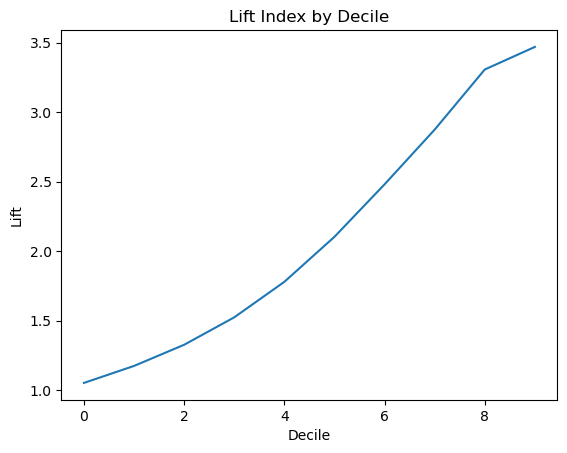

Top-Decile Lift: 3.468421052631579
Lift Index: 2.1092903248789563
Lift for each decile:
decile
0    1.053206
1    1.175360
2    1.327504
3    1.524672
4    1.779902
5    2.103410
6    2.480614
7    2.873837
8    3.305976
9    3.468421
Name: lift, dtype: float64


In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

def test():
    # Predict probabilities
    clf = grid_results['ebm']['eprofits']['_best']
    y_probs = clf.predict_proba(x_test)[:, 1]
    
    # Create a DataFrame with true labels and predicted probabilities
    df_lift = pd.DataFrame({'true_labels': y_test, 'pred_probs': y_probs})
    
    # Sort the DataFrame by predicted probabilities in descending order
    df_lift = df_lift.sort_values(by='pred_probs', ascending=False)
    print(df_lift.shape)
    # display(df_lift.head(n=150))
    
    # Calculate the overall churn rate
    overall_churn_rate = df_lift['true_labels'].mean()
    
    # Top-Decile Lift calculation
    top_decile = df_lift.head(int(len(df_lift) * 0.1))
    top_decile_lift = top_decile['true_labels'].mean() / overall_churn_rate

    print(top_decile_lift)
    
    # Divide the data into deciles
    df_lift['decile'] = pd.qcut(df_lift['pred_probs'].rank(method='first'), 10, labels=False) # first decile is actually the last one
    deciles_churners = df_lift.groupby('decile')['true_labels'].sum().to_frame()
    deciles_churners['weight'] = np.arange(0.1, 1.1, 0.1) # first decile is actually the last one
    deciles_churners['w_churners'] = deciles_churners['weight'] * deciles_churners['true_labels']
    print('Lift Index', deciles_churners['w_churners'].sum()/deciles_churners['true_labels'].sum())
    display(deciles_churners)
    
    
    # Calculate the cumulative churn rate for each decile
    df_lift['cumulative_churn'] = df_lift['true_labels'].cumsum() / (np.arange(len(df_lift)) + 1)
    
    # Calculate the Lift for each decile
    df_lift['lift'] = df_lift['cumulative_churn'] / overall_churn_rate
    
    # Calculate the average Lift for each decile
    lift_deciles = df_lift.groupby('decile')['lift'].mean()
    
    # Lift Index calculation
    lift_index = lift_deciles.mean()
    
    # Plot the Lift Index
    plt.plot(lift_deciles)
    plt.xlabel('Decile')
    plt.ylabel('Lift')
    plt.title('Lift Index by Decile')
    plt.show()
    
    # Print Top-Decile Lift, Lift Index, and Lift
    print(f'Top-Decile Lift: {top_decile_lift}')
    print(f'Lift Index: {lift_index}')
    print('Lift for each decile:')
    print(lift_deciles)

test()

via eprofits


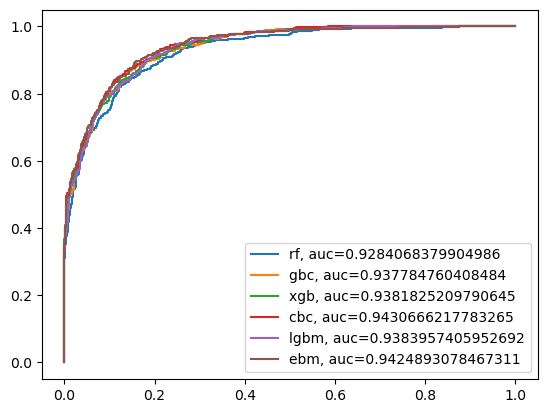

In [70]:
import matplotlib.pyplot as plt


def test_roc(sc_policy):
    y_true = y_test # ground truth labels
    print('via', sc_policy)
    for clf, name, no_df in get_models(grid_results, sc_policy):
        if no_df:
            x_tr, x_te = x_train, x_test
        else:
            x_tr, x_te = x_train.values,  x_test.values
        y_scores = clf.predict_proba(x_te)[:, 1]
   
    
    
        y_probas = y_scores # predicted probabilities generated by sklearn classifier
        fpr, tpr, _ = metrics.roc_curve(y_true,  y_probas)
        auc = metrics.roc_auc_score(y_true, y_probas)
        plt.plot(fpr,tpr,label= name + ", auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

test_roc('eprofits')

In [71]:
x_train

,gender,age,married,numberofdependents,city,numberofreferrals,tenureinmonths,offer,phoneservice,avgmonthlylongdistancecharges,...,contract,paperlessbilling,paymentmethod,monthlycharge,totalcharges,totalrefunds,totalextradatacharges,totallongdistancecharges,totalrevenue,customer_value
1114,0,30,0,0,664,0,54,1,1,37.65,...,1,1,0,94.75,5121.75,0.0,70,2033.10,7224.85,131.360909
798,0,53,1,0,348,4,72,5,1,2.95,...,2,1,0,91.15,6637.90,0.0,0,212.40,6850.30,93.839726
4623,1,27,0,0,554,0,47,5,1,6.61,...,2,0,0,20.45,943.00,0.0,0,310.67,1253.67,26.118125
298,1,47,0,0,757,0,43,1,1,49.13,...,0,1,0,77.85,3365.85,0.0,0,2112.59,5478.44,124.510000
2879,0,23,0,0,787,0,42,1,1,29.44,...,1,1,0,60.15,2421.60,0.0,0,1236.48,3658.08,85.071628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,1,29,0,0,654,0,41,1,1,21.64,...,2,1,1,99.65,4220.35,0.0,0,887.24,5107.59,121.609286
5191,0,32,0,0,820,0,2,5,1,41.37,...,0,1,0,75.55,166.30,0.0,0,82.74,249.04,83.013333
5226,0,49,1,1,680,10,53,1,1,30.31,...,1,0,0,19.55,1007.90,0.0,0,1606.43,2614.33,48.413519
5390,0,26,0,1,447,0,43,5,1,5.60,...,0,1,0,63.95,2737.05,0.0,0,240.80,2977.85,67.678409


In [72]:
grid_results['ebm']['eprofits']['_best']

ExplainableBoostingClassifier(interactions=10, learning_rate=0.01, max_bins=128,
                              max_interaction_bins=16)

In [73]:

def test_grid():
    # Profit_Margin = 0.3
    # Cost_of_Contact = (0, 0.3)
    # CPO = 0.1
    # def custom_eprofits_function(df, Profit_Margin, Cost_of_Contact, CPO):
    #     def custom_scorer(y_true, y_pred):
    #         my_df = df.loc[y_true.index]
    #         my_df['true'] = y_true
    #         my_df['predict'] = y_pred
    #         return _eprofits(my_df, Profit_Margin, Cost_of_Contact, CPO)
    #     return metrics.make_scorer(custom_scorer, greater_is_better=True)

    # df_profit_scorer = pd.DataFrame({'customer_value': x_train['customer_value'], 'retention_rate': x_train[tenure_column].apply(retention_fn)})
    # profit_scorer = custom_eprofits_function(df_profit_scorer, Profit_Margin, Cost_of_Contact, CPO)

    # Define the custom scorer function
    def emp_scorer(estimator, X, y):
        # Use the model to predict probabilities
        y_proba = estimator.predict_proba(X)[:, 1]  # Assuming binary classification and taking the probability of class 1
        return empChurn(y_proba, y, alpha=6, beta=14, clv=200, d=10, f=1, print_output=False, return_output=True, rounding=None).EMP
    
    # Create the custom scorer using make_scorer
    custom_emp_function = metrics.make_scorer(emp_scorer, greater_is_better=True, needs_proba=True)
    
    scoring = {
        # 'AUC': metrics.make_scorer(metrics.roc_auc_score),
        # 'accuracy': metrics.make_scorer(metrics.accuracy_score),
        # 'f1': metrics.make_scorer(metrics.f1_score),
        # 'emp': emp_scorer,
        'emp': custom_emp_function,
        # 'profit': profit_scorer
    }
    
    _xgb = xgb.XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss')
    clf, param_grid = _xgb, param_grid_xgb
    refit = list(scoring.keys())[0]
    if refit == 'emp':
        n_jobs = 1
    else:
        n_jobs = -1
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring=scoring, refit=refit, n_jobs=n_jobs, verbose=1)  # n_jobs=-1 is a bit buggy
    grid_search.fit(x_train.iloc[:], y_train.iloc[:])

    my_x_test = x_test.iloc[:]
    my_y_test = y_test.iloc[:]
    # Evaluate the best CBC model
    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(my_x_test)
    y_prob = best_clf.predict_proba(my_x_test)[:, 1]
    roc_auc = metrics.roc_auc_score(my_y_test, y_prob)
    clf = best_clf
    
    print(f'Best AUC: {roc_auc}')
    my_df = pd.DataFrame({'customer_value': my_x_test['customer_value'], 'retention_rate': my_x_test[tenure_column].apply(retention_fn), 'true': my_y_test, 'predict': y_pred})
    print('Profit', _eprofits(my_df, Profit_Margin=Profit_Margin, Cost_of_Contact= Cost_of_Contact, CPO=0.1, verbose=0))
    # print(best_clf)
    print(metrics.classification_report(my_y_test, y_pred))
    cm = metrics.confusion_matrix(my_y_test, y_pred, labels=clf.classes_)
    print(cm)
    # disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
    #                           display_labels=clf.classes_)
    # disp.plot()
    # plt.show()
    

test_grid()

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best AUC: 0.9187003578598238
Profit 34366.28365721179
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1407
           1       0.99      0.32      0.48       570

    accuracy                           0.80      1977
   macro avg       0.89      0.66      0.68      1977
weighted avg       0.84      0.80      0.76      1977

[[1406    1]
 [ 390  180]]
